##### Project 2 - Big-Scale Analysis 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
# Kaggle: Real or Not? NLP with Disaster Tweets

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [24]:
# A disaster tweet
disaster_tweet = train[train['Target'] == 1]['Tweet text']
disaster_tweet.values[1]

'Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read \x89Û_ http://t.co/nosA8JJjiN http://t.co/WUKvdavUJu'

In [25]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['Target'] == 0]['Tweet text']
non_disaster_tweet.values[1]

'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries

In [21]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alixm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# II. EDA

## 1. Training set

### Data loading

In [22]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

In [23]:
train.columns = ['ID', 'Keyword', 'Location', 'Tweet text', 'Target']
train.head()

,ID,Keyword,Location,Tweet text,Target
4147,5894,harm,where the wild things are,I concur. The longer you spend with your child...,0
2675,3837,detonate,Worldwide,Apollo Brown - Detonate (Ft. M.O.P.) https://t...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
896,1297,bloody,65,@zhenghxn i tried 11 eyes akame ga kill and to...,0
6488,9276,sunk,New York,Aquarium Ornament Wreck Sailing Boat Sunk Ship...,1


### Distribution of the target column

In [26]:
#when the target = 1 it means the the tweet is about a disaster
train_yes = train.query('Target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters (Target = 0).')

#when the target = 0 it means the the tweet is not about a disaster
train_no = train.query('Target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters (Target = 1).')

There are 3271 tweets about disasters (Target = 0).
There are 4342 tweets that are not about disasters (Target = 1).


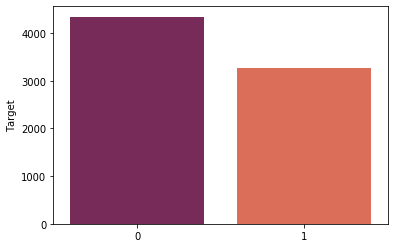

In [27]:
sns.barplot(train['Target'].value_counts().index, train['Target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

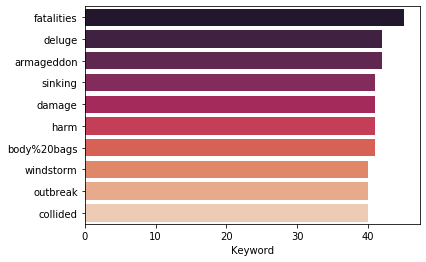

In [28]:
sns.barplot(y = train['Keyword'].value_counts()[:10].index, x = train['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [29]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

1    102
0     40
Name: Target, dtype: int64

## 2. Test set

### Data loading

In [30]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

(3263, 4)

In [31]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

,ID,Keyword,Location,Tweet text
2163,7243,natural%20disaster,NaN,TRAIN ACCIDENT IN HARDA (M.P.) IS NOT NATURAL ...
277,908,bioterrorism,NaN,HST's Anthony Kimery Discusses #BioTerrorism o...
199,645,arsonist,Fresno,Arson suspect linked to 30 fires caught in Nor...
156,511,army,NaN,Beyonce Is my pick for http://t.co/nnMQlz91o9 ...
3098,10257,war%20zone,Miami,My new sounds: War Zone https://t.co/hNXRfqRk3...


### Distribution of the Keyword column

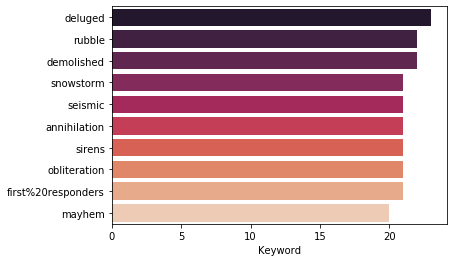

In [32]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [33]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

4147    i concur the longer you spend with your child ...
2675                  apollo brown  detonate ft mop  fiya
32             we always try to bring the heavy metal rt 
896     zhenghxn i tried  eyes akame ga kill and tokyo...
6488    aquarium ornament wreck sailing boat sunk ship...
Name: Tweet text, dtype: object

In [34]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

2163    train accident in harda mp is not natural disa...
277     hsts anthony kimery discusses bioterrorism on ...
199     arson suspect linked to  fires caught in north...
156            beyonce is my pick for  fan army beyhive  
3098                my new sounds war zone  on soundcloud
Name: Tweet text, dtype: object

In [35]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

4147    [i, concur, the, longer, you, spend, with, you...
2675             [apollo, brown, detonate, ft, mop, fiya]
32      [we, always, try, to, bring, the, heavy, metal...
896     [zhenghxn, i, tried, eyes, akame, ga, kill, an...
6488    [aquarium, ornament, wreck, sailing, boat, sun...
Name: Tweet text, dtype: object

In [36]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

2163    [train, accident, in, harda, mp, is, not, natu...
277     [hsts, anthony, kimery, discusses, bioterroris...
199     [arson, suspect, linked, to, fires, caught, in...
156      [beyonce, is, my, pick, for, fan, army, beyhive]
3098         [my, new, sounds, war, zone, on, soundcloud]
Name: Tweet text, dtype: object

In [37]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

4147            [concur, longer, spend, child, harm, mmk]
2675             [apollo, brown, detonate, ft, mop, fiya]
32                 [always, try, bring, heavy, metal, rt]
896     [zhenghxn, tried, eyes, akame, ga, kill, tokyo...
6488    [aquarium, ornament, wreck, sailing, boat, sun...
Name: Tweet text, dtype: object

In [38]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

2163    [train, accident, harda, mp, natural, disaster...
277     [hsts, anthony, kimery, discusses, bioterroris...
199     [arson, suspect, linked, fires, caught, northe...
156                   [beyonce, pick, fan, army, beyhive]
3098                 [new, sounds, war, zone, soundcloud]
Name: Tweet text, dtype: object

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)